# RUN PERFORMANCE PROJECT - Pau Sampietro  

## *Predicting future races:* K-NEIGHBORS REGRESSOR ALGORITHM

In this notebook we will perform the K-Nearest Neighbors algorithm. In this case we have some options to manipulate hyperparameters, what could provide a better fitted model with our data. On the other hand, knowing how KNeighbors compute the regression, we think that the main problems will be:
* As we have data of previous **short races** (10 km, 21 km) the algorithm will probably take this values as the nearest, giving as a prediction the same time performed for the athlete, which is not very useful.
* As we do not have much more data of **long runs** (marathon), the nearest points won't be really accurate for predicting the result

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.plotly as py
import matplotlib.pyplot as plt
import cufflinks as cf 
from ipywidgets import interact
import plotly.graph_objs as go
from rpdb import read_table, read_table_sql, export_table
from datetime import datetime

#### Import tables of filtered moves  and scheduled races to predict from the Database 

In [3]:
moves_feat = read_table('moves_feat')
moves_feat.head()

,index,distance,accum_ascent,ascent_ratio,calories,heart_rate,days_from,moving_time
0,0,4019.0,280.0,69.7,670.0,166.0,659,29.8
1,1,4995.0,63.0,12.6,585.0,168.0,659,30.9
2,2,4374.0,115.0,26.3,602.0,180.0,642,22.6
3,3,3005.0,91.0,30.3,365.0,167.0,641,16.9
4,4,6540.0,241.0,36.9,760.0,161.0,637,42.0


In [4]:
races = read_table('races')
races

,index,name,distance,accum_ascent,days_from,lr_pred
0,0,delta prat,10000.0,25.0,-13,36.639508
1,1,catllaras,42300.0,2700.0,-27,452.950483
2,2,stockholm,42195.0,172.0,-40,163.870622
3,3,ulldeter,21000.0,1300.0,-62,219.990278


### 1. K-Nearest Neighbors Algorithm model

#### 1.1. Fitting KNeighbors preliminar model (default parameter: k = 3)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

In [6]:
X = moves_feat.drop(columns='moving_time')
y = moves_feat['moving_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 32)

In [7]:
KN_reg = KNeighborsRegressor(n_neighbors=5)
KN_reg.fit(X_train, y_train)

# predictions done with the model
y_pred = KN_reg.predict(X_test)

In [8]:
# Printing the metrics for the model
print("* Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('* Variance score: %.2f' % r2_score(y_test, y_pred))

* Mean squared error: 523.17
* Variance score: 0.61


*As we can see, the result of the r2 score is lower than with linear regression. As we could see in the clustering preliminar analysis, looking for the neighbors not always returns good results when the moves are not strictly separated.* The MSE is also too high.

* Performing a **cross-validated** score

In [9]:
scores = cross_val_score(KN_reg, X,  y, cv=5)
print(f'* CV scores: {scores}')
print('* Mean Variance score: %.2f' % scores.mean())

* CV scores: [0.91045739 0.87493182 0.82630386 0.59678034 0.47977652]
* Mean Variance score: 0.74


#### 1.2. Hyperparameter tuning (K-Neighbors and weights)

In the cells below we loop over some combination of hyperparameters of the algorithm, in order to improve the results of the model. We also plot the best combinations of hyperparameters, whose are giving the most accurate results based on the same metrics as in linear regression (R2 score)

In [11]:
# Selecting as a training features those that we will have as input for predictions
X = X[['accum_ascent','distance']]

neighbors = list(range(1,50,2))
scores_u = []
scores_d = []
cross_sc_std_u = []
cross_sc_std_d = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors = k, weights = 'uniform')
    scores = cross_val_score(knn, X, y, cv=7)
    scores_u.append(scores.mean())
    cross_sc_std_u.append(scores.std())

    knn = KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    scores = cross_val_score(knn, X, y, cv=7)
    scores_d.append(scores.mean())
    cross_sc_std_d.append(scores.std())   

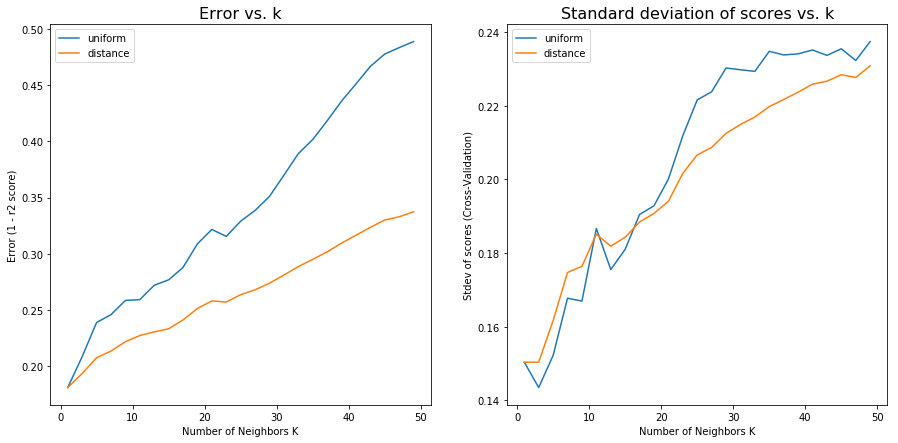

* With "uniform" optimal k = 1 with Mean Score = 0.8191791613709306. Stdev scores = 0.15037282173813027
* With "distance" optimal k = 1 with Mean Score = 0.8191791613709306. Stdev scores = 0.15037282173813027


In [12]:
Err_u = [1-x for x in scores_u]
Err_d = [1-x for x in scores_d]

# plot error vs k and standard deviation of scores vs. k.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.plot(neighbors, Err_u)
ax1.plot(neighbors, Err_d)
ax1.set_xlabel('Number of Neighbors K')
ax1.set_ylabel('Error (1 - r2 score)')
ax1.legend(['uniform','distance'])
ax1.set_title('Error vs. k', fontsize = 16)

ax2.plot(neighbors, cross_sc_std_u)
ax2.plot(neighbors, cross_sc_std_d)
ax2.set_xlabel('Number of Neighbors K')
ax2.set_ylabel('Stdev of scores (Cross-Validation)')
ax2.legend(['uniform','distance'])
ax2.set_title('Standard deviation of scores vs. k', fontsize = 16)

plt.show()

print(f'* With "uniform" optimal k = {neighbors[Err_u.index(min(Err_u))]} with Mean Score = {1-min(Err_u)}. Stdev scores = {cross_sc_std_u[Err_u.index(min(Err_u))]}')
print(f'* With "distance" optimal k = {neighbors[Err_d.index(min(Err_d))]} with Mean Score = {1-min(Err_d)}. Stdev scores = {cross_sc_std_d[Err_d.index(min(Err_d))]}')


As we can see, now we obtain better results, and they are both similar with both 'uniform' and 'distance' weighting of the data. All of this calculations are based on the Train set (the races that have been already done). Once we fit the optimal model, we will predict future races in the cells below.

* *Analyzing **stability of r2 scores** during cross-validation*

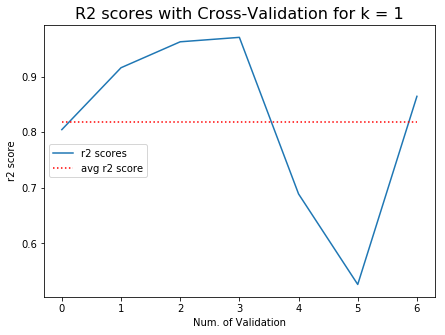

In [13]:
knn = KNeighborsRegressor(n_neighbors = 1, weights = 'uniform')
scores = cross_val_score(knn, X, y, cv=7)
plt.figure(figsize=(7,5))
plt.plot(range(7), scores)
plt.plot(range(7), [scores.mean() for i in range(7)], 'r',  linestyle=':')
plt.xlabel('Num. of Validation')
plt.ylabel('r2 score')
plt.title('R2 scores with Cross-Validation for k = 1', fontsize = 16)
plt.legend(['r2 scores','avg r2 score'], loc=6)
plt.show()

Note that having a spreaded r2 score while doing cross-validation is not good, and we are probably overfitting some data and the model is not good enought to generalize

#### 1.3. Calculating predictions for next given races with actual model:

Predictions are for the following races:
* Delta Prat Race: 10 km, 25 m ascent, 5 may 2019
* Marathon Catllaràs: 42 km, 2700 m ascent, 19 may 2019
* Stockholm Marathon: 42 km, 172 m ascent, 1 june 2019
* Trail Ulldeter: 21 km, 1300 m ascent, 23 june 2019

In [14]:
KN_reg_optimal = KNeighborsRegressor(n_neighbors=1, weights='uniform')
KN_reg_optimal.fit(X, y)

races_kn_pred = KN_reg_optimal.predict(races[['accum_ascent','distance']])
print(f'* KN predictions for given races: {races_kn_pred}')

* KN predictions for given races: [ 43.5 321.  321.  115.4]


* Including results of KN regression predictions in the races dataframe

In [15]:
races = read_table('races')
races['kn_pred'] = races_kn_pred
export_table(races.drop(columns='index'), 'races')

*** *COMMENTS***: The r2 score of this model is lower than with Linear regression. However, the results above shows some interesting conclusions in accordance with hypothesis explained at the beginning: 
* 10k race is predicted almost perfectly. **Delta Prat 10k: 43.5 min** (This is, in fact, Pau's personal best!!!)
* Long races (both Cross-country and urban) are the worst predictions as we do not have much near data.